In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import eli5
from eli5.sklearn import PermutationImportance

from sklearn.naive_bayes import ComplementNB, GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve, classification_report


def reduce_mem_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
 
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
data = reduce_mem_usage(pd.read_csv("My_final_data_without_missing_values_or_catigorical_features.csv"))
data.drop('Unnamed: 0',axis=1,inplace=True)
data.info()

Memory usage of dataframe is 207.03 MB --> 46.58 MB (Decreased by 77.5%)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Columns: 239 entries, Term to IncomeRange_Not employed
dtypes: float32(63), int8(176)
memory usage: 46.2 MB


In [4]:
data.loc[data["ProsperScore"]==11,"ProsperScore"]=10

In [8]:
X_train,X_test,y_train,y_test = train_test_split(
    data.drop('LoanStatus_Completed',axis=1),data['LoanStatus_Completed'],test_size=0.25,random_state=1111)

model3 = BernoulliNB()

searcher3 = GridSearchCV(model3, {'alpha':[0, 0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.6, 1]}, cv=5)
searcher3.fit(X_train, y_train)

print("Best CV params", searcher3.best_params_)

best_NB3 = searcher3.best_estimator_
coefs3 = best_NB3.coef_
print("Total number of features:", coefs3.size)
print("Number of selected features:", np.count_nonzero(coefs3))
y_predNB3 = best_NB3.predict(X_test)
print("The Accuracy on unseen data:", accuracy_score(y_predNB3,y_test))

C:\Users\m2021\anaconda3\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\m2021\anaconda3\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\m2021\anaconda3\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\m2021\anaconda3\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\m2021\anaconda3\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in n

Best CV params {'alpha': 0}
Total number of features: 238
Number of selected features: 238
The Accuracy on unseen data: 0.9649060742208229


C:\Users\m2021\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


In [10]:
permNB3 = PermutationImportance(searcher3, random_state=1).fit(X_test, y_test)
eli5.show_weights(permNB3, feature_names = X_test.columns.tolist())

Weight,Feature
0.1530 ± 0.0032,IsClosed
0.1486 ± 0.0017,LoanStatus_Current
0.1485 ± 0.0024,IsInProgress
0.0430 ± 0.0011,LP_GrossPrincipalLoss
0.0425 ± 0.0010,LoanCurrentDaysDelinquent
0.0418 ± 0.0019,LP_NetPrincipalLoss
0.0323 ± 0.0013,exclude_recoveries
0.0317 ± 0.0017,LoanStatus_Chargedoff
0.0146 ± 0.0010,LoanStatus_Defaulted
0.0129 ± 0.0008,Is_ChargedOff


In [11]:
print(classification_report(y_test,y_predNB3))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     18813
           1       1.00      0.90      0.94      9454

    accuracy                           0.96     28267
   macro avg       0.97      0.95      0.96     28267
weighted avg       0.97      0.96      0.96     28267



### auc score and roc curve on testing data

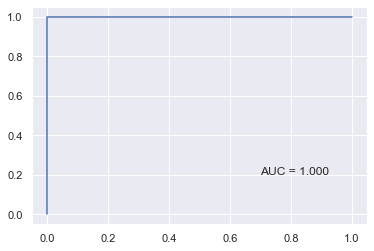

In [12]:
fpr3,tpr3,hp3=roc_curve(y_test,best_NB3.predict_proba(X_test)[:,1])
auc3=roc_auc_score(y_test,best_NB3.predict_proba(X_test)[:,1])
plt.plot(fpr3,tpr3)
plt.text(0.7,0.2,"AUC = "+"{:.3f}".format(auc3))
plt.show()

### auc score and roc curve on training data

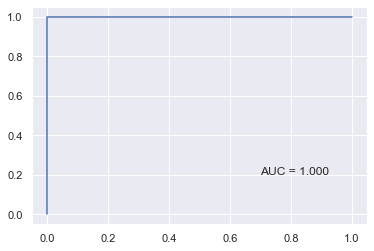

In [13]:
fpr31,tpr31,hp31=roc_curve(y_train,best_NB3.predict_proba(X_train)[:,1])
auc31=roc_auc_score(y_train,best_NB3.predict_proba(X_train)[:,1])
plt.plot(fpr31,tpr31)
plt.text(0.7,0.2,"AUC = "+"{:.3f}".format(auc31))
plt.show()

# ----------------------------------------------------------------------------------------------------

### maybe for the previous data we have some kinda of data leak so i wil try a gain on different data

In [ ]:
data = reduce_mem_usage(pd.read_csv('final2_prosper_dataset.csv'))
data['average_income'] = (data['MinIncome']+ data['MaxIncome'])/2
data.drop('Unnamed: 0',axis=1,inplace=True)
data.drop(["ListingCreationDate","FirstRecordedCreditLine","IncomeRange","LoanOriginationDate","DateCreditPulled"],axis=1,inplace=True)
risk = ['ProsperRating (numeric)','ProsperRating (Alpha)','ProsperScore','high_risk']
CreditScore = ['CreditScoreRangeLower','CreditScoreRangeUpper']
data['ProsperRating (Alpha)'].value_counts(normalize=True)

In [15]:
data.loc[data["ProsperScore"]==11,"ProsperScore"]=10
df = data.copy()
df.drop(CreditScore,axis=1,inplace=True)
df = df.drop('LoanKey',axis=1)
df = df.drop(['MinIncome','MaxIncome'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 84 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   CreditGrade                         113066 non-null  object 
 1   Term                                113066 non-null  int8   
 2   BorrowerAPR                         113066 non-null  float32
 3   BorrowerRate                        113066 non-null  float32
 4   LenderYield                         113066 non-null  float32
 5   EstimatedEffectiveYield             113066 non-null  float32
 6   EstimatedLoss                       113066 non-null  float32
 7   EstimatedReturn                     113066 non-null  float32
 8   ProsperRating (numeric)             113066 non-null  float32
 9   ProsperRating (Alpha)               113066 non-null  object 
 10  ProsperScore                        113066 non-null  float32
 11  ListingCategory (numeric) 

In [21]:
X = df.iloc[:,:71]
y= df['LoanStatus_Completed']

In [22]:
X = pd.get_dummies(X,columns=[col for col in X.columns if 'O' == X[col].dtype])
X.head()

,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,ListingCategory (numeric),...,Occupation_Truck Driver,Occupation_Waiter/Waitress,EmploymentStatus_Employed,EmploymentStatus_Full-time,EmploymentStatus_Not available,EmploymentStatus_Not employed,EmploymentStatus_Other,EmploymentStatus_Part-time,EmploymentStatus_Retired,EmploymentStatus_Self-employed
0,36,0.16516,0.1580,0.1380,0.16162,0.0724,0.09211,4.0,7.0,0,...,0,0,0,0,0,0,0,0,0,1
1,36,0.12016,0.0920,0.0820,0.07960,0.0249,0.05470,6.0,7.0,2,...,0,0,1,0,0,0,0,0,0,0
2,36,0.28269,0.2750,0.2400,0.16162,0.0724,0.09211,4.0,7.0,0,...,0,0,0,0,1,0,0,0,0,0
3,36,0.12528,0.0974,0.0874,0.08490,0.0249,0.06000,6.0,9.0,16,...,0,0,1,0,0,0,0,0,0,0
4,36,0.24614,0.2085,0.1985,0.18316,0.0925,0.09066,3.0,4.0,2,...,0,0,1,0,0,0,0,0,0,0


In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1111)

model3_1=BernoulliNB()

searcher3_1=GridSearchCV(model3_1, {'alpha':[0, 0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.6, 1]}, cv=5)
searcher3_1.fit(X_train, y_train)

print("Best CV params", searcher3_1.best_params_)

best_NB3_1 = searcher3_1.best_estimator_
coefs3_1 = best_NB3_1.coef_
print("Total number of features:", coefs3_1.size)
print("Number of selected features:", np.count_nonzero(coefs3_1))
y_predNB3_1 = best_NB3_1.predict(X_test)
print("The Accuracy on unseen data:", accuracy_score(y_predNB3_1,y_test))

C:\Users\m2021\anaconda3\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\m2021\anaconda3\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\m2021\anaconda3\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\m2021\anaconda3\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\m2021\anaconda3\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in n

Best CV params {'alpha': 0}
Total number of features: 208
Number of selected features: 208
The Accuracy on unseen data: 0.9216754519404252


C:\Users\m2021\anaconda3\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\m2021\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


In [26]:
permNB3_1 = PermutationImportance(searcher3_1, random_state=1).fit(X_test, y_test)
eli5.show_weights(permNB3_1, feature_names = X_test.columns.tolist())

Weight,Feature
0.1314 ± 0.0016,IsClosed
0.1266 ± 0.0024,IsInProgress
0.0439 ± 0.0007,LoanCurrentDaysDelinquent
0.0390 ± 0.0011,LP_NetPrincipalLoss
0.0386 ± 0.0018,LP_GrossPrincipalLoss
0.0273 ± 0.0012,exclude_recoveries
0.0133 ± 0.0009,Is_ChargedOff
0.0073 ± 0.0011,LP_NonPrincipalRecoverypayments
0.0045 ± 0.0006,LP_CustomerPrincipalPayments
0.0044 ± 0.0007,accompanied_delinquencyBucket


In [27]:
print(classification_report(y_test,y_predNB3_1))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18813
           1       1.00      0.77      0.87      9454

    accuracy                           0.92     28267
   macro avg       0.95      0.88      0.91     28267
weighted avg       0.93      0.92      0.92     28267



### auc score and roc curve on testing data

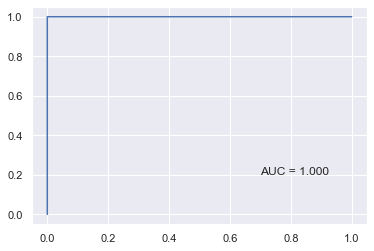

In [28]:
fpr3_1,tpr3_1,hp3_1=roc_curve(y_test,best_NB3_1.predict_proba(X_test)[:,1])
auc3_1=roc_auc_score(y_test,best_NB3_1.predict_proba(X_test)[:,1])
plt.plot(fpr3_1,tpr3_1)
plt.text(0.7,0.2,"AUC = "+"{:.3f}".format(auc3_1))
plt.show()

### auc score and roc curve on training data

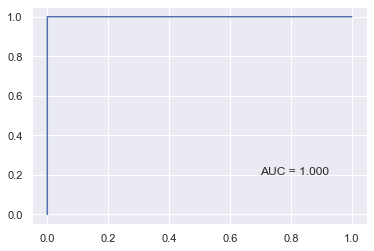

In [29]:
fpr31_1,tpr31_1,hp31_1=roc_curve(y_train,best_NB3_1.predict_proba(X_train)[:,1])
auc31_1=roc_auc_score(y_train,best_NB3_1.predict_proba(X_train)[:,1])
plt.plot(fpr31_1,tpr31_1)
plt.text(0.7,0.2,"AUC = "+"{:.3f}".format(auc31_1))
plt.show()